In [1]:
import loadcsvs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.ticker import LogLocator

# LaTeX font setup
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 10
})

In [2]:
directory = '/home/lanpirot/data/builder'
df = loadcsvs.process_directory(directory)
df.columns = df.columns.str.strip()

Processed: /home/lanpirot/data/builder/archive2/0/GIANT/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/0/AST_MODEL/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/0/DEPTH/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/0/WIDTH/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/0/SLNET/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/0/RANDOM/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/GIANT/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/AST_MODEL/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/DEPTH/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/WIDTH/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/SLNET/synth_report.csv
Processed: /home/lanpirot/data/builder/archive2/1/RANDOM/synth_report.csv


In [3]:
df = df.dropna(subset=['depth'])
good_models = df.dropna()
bad_models = df[df['save_time'].isna()]
print(f"Only {len(bad_models)/len(df)*100:.3g}% of the models have a failed synthesis.")


Only 59.4% of the models have a failed synthesis.


In [6]:
df['build_time'] = df['elements']/df['build_time']
df['save_time'] = df['elements']/df['save_time']

/tmp/ipykernel_808185/62261553.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


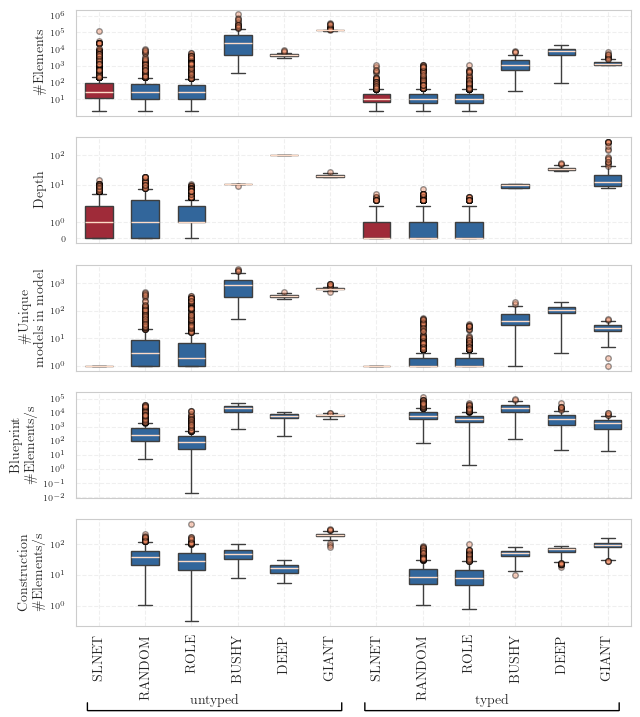

In [30]:
# Constants
BOX_WIDTH = 0.6
BRACKET_Y_POS = -0.8
LABEL_Y_POS = BRACKET_Y_POS + 0.15
COLORS = {
    "box": "#2166acff",
    "median": "#fddbc7ff",
    "outlier": "#ef8a62ff",
    "slnet": "#b2182bff"
}
MODE_MAPPING = {
    "SLNET": "SLNET",
    "ROLE": "AST_MODEL",
    "BUSHY": "WIDTH",
    "DEEP": "DEPTH",
    "RANDOM": "RANDOM",
    "GIANT": "GIANT"
}
YLABEL_MAPPING = {
    "depth": "Depth",
    "unique_models": "\\#Unique\nmodels in model",
    "unique_subsystems": "\\#Unique\nSubsystems",
    "build_time": "Blueprint\n\\#Elements/s",
    "save_time": "Construction\n\\#Elements/s",
    "elements": "\\#Elements",
    "subs": "\\#Subsystems"
}

FONT_SIZE = 10
# LaTeX font setup
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": FONT_SIZE
})

def plot_boxplot_group(ax, data, positions, color, median_color, outlier_color):
    sns.boxplot(
        data=data, ax=ax, positions=positions, width=BOX_WIDTH,
        color=color, medianprops={"color": median_color, "linewidth": 1},
        flierprops={
            "marker": "o",
            "markerfacecolor": outlier_color,
            "markeredgecolor": "black",
            "markersize": 4,
            "alpha": 0.4
        }
    )

def add_group_bracket(ax, start, end, label):
    ax.annotate("", xy=(end, BRACKET_Y_POS), xycoords=('data', 'axes fraction'),
                xytext=(start, BRACKET_Y_POS), textcoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle="-", color="black"))
    ax.annotate("", xy=(start+0.05, BRACKET_Y_POS-0.025), xycoords=('data', 'axes fraction'),
                xytext=(start+0.05, BRACKET_Y_POS + 0.1), textcoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle="-", color="black"))
    ax.annotate("", xy=(end-0.05, BRACKET_Y_POS-0.025), xycoords=('data', 'axes fraction'),
                xytext=(end-0.05, BRACKET_Y_POS + 0.1), textcoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle="-", color="black"))
    ax.annotate(label, xy=((start + end)/2, LABEL_Y_POS), xycoords=('data', 'axes fraction'),
                ha="center", va="top", fontsize=FONT_SIZE)

# Metrics and modes
metrics = ["elements", "depth", "unique_models", "build_time", "save_time"]
modes = ["SLNET", "RANDOM", "ROLE", "BUSHY", "DEEP", "GIANT"]
c0_positions = list(range(len(modes)))
c1_positions = [pos + len(modes) for pos in c0_positions]
positions = c0_positions + c1_positions
mode_labels = [*modes, *modes]

# Create figure
fig, axes = plt.subplots(
    nrows=len(metrics), ncols=1,
    figsize=(7.16, 8),
    sharex=True,
    gridspec_kw={"hspace": 0.2}
)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot c=0
    for j, mode in enumerate(modes):
        if mode == "SLNET":
            if metric in ["build_time", "save_time"]:
                continue
            box_color = COLORS["slnet"]
        else:
            box_color = COLORS["box"]
        search_mode = MODE_MAPPING.get(mode, mode)
        data = df[(df["mode"] == search_mode) &
                          (df["needs_to_be_compilable"] == 0)][metric]
        plot_boxplot_group(ax, data, [c0_positions[j]], box_color, COLORS["median"], COLORS["outlier"])

    # Plot c=1
    for j, mode in enumerate(modes):
        if mode == "SLNET":
            if metric in ["build_time", "save_time"]:
                continue
            box_color = COLORS["slnet"]
        else:
            box_color = COLORS["box"]
        search_mode = MODE_MAPPING.get(mode, mode)
        data = df[(df["mode"] == search_mode) &
                          (df["needs_to_be_compilable"] == 1)][metric]
        plot_boxplot_group(ax, data, [c1_positions[j]], box_color, COLORS["median"], COLORS["outlier"])


    # Customize
    if i == len(metrics) - 1:
        ax.set_xticks(positions)
        ax.set_xticklabels(mode_labels, rotation=90, ha="center", fontsize=FONT_SIZE)
    else:
        ax.set_xticklabels([])
    ax.set_ylabel(YLABEL_MAPPING[metric])
    ax.tick_params(axis='y', labelsize=FONT_SIZE-4)
    ax.set_ylabel(YLABEL_MAPPING[metric], fontsize=FONT_SIZE)
    ax.set_yscale('log')
    if metric == "depth":
        ax.set_yscale('symlog')
    ax.grid(True, which="major", linestyle="--", alpha=0.3)
    if metric == "build_time":
        ax.set_yticks([0.01,0.1,1,10,100,1000,10000,100000])
        #ax.yaxis.set_major_locator(LogLocator(base=10, numticks=5))

# Add brackets
ax = axes[-1]
add_group_bracket(ax, -0.3, 5.3, "untyped")
add_group_bracket(ax, 5.7, 11.3, "typed")
ax.set_xlim(-0.5, 11.5)

# Save
plt.tight_layout()
plt.savefig("boxplot_panel.pdf", bbox_inches="tight", dpi=300)
plt.show()
